## Panasonic SOC Prediction - Long Short Term Memory Networks (LSTM)
Panasonic 18650PF Li-ion Battery Data - https://data.mendeley.com/datasets/wykht8y7tg/1

Kollmeyer, Phillip (2018), “Panasonic 18650PF Li-ion Battery Data”, Mendeley Data, V1, doi: 10.17632/wykht8y7tg.1

In [2]:
import os
import sys
import IPython
import IPython.display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import collections
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.layers.core import Dense
from tensorflow.keras import layers

cell_type = "panasonic"
model_type = "lstm_model"
base_path = '../../'

sys.path.append(base_path)
from training import utils

panasonic_data_path = base_path + 'datasets/Panasonic_18650PF'
lg_data_path = base_path + 'datasets/LG_18650HG2'
pre_trained_path = base_path + 'pre-trained/' + cell_type + '_' + model_type

resample_1hz = False
vi_averages = True

## Panasonic Test, Train Processing

In [4]:
panasonic_test_temps = ['n10degC', '0degC', '10degC', '25degC']
panasonic_test_discharge_cycles = ['US06', 'LA92', 'NN']

panasonic_train_temps = ['n10degC', '0degC', '10degC', '25degC']
panasonic_train_discharge_cycles = ['UDDS', 'HWFET', 'HWFT']

panasonic_train_files = utils.panasonic_get_files(panasonic_data_path,
                                                  panasonic_train_discharge_cycles, 
                                                  panasonic_train_temps)

panasonic_test_files = utils.panasonic_get_files(panasonic_data_path, 
                                                 panasonic_test_discharge_cycles,
                                                 panasonic_test_temps)

for file in panasonic_train_files:
    if "UDDS_LA92" in file or "LA92_NN" in file:
        panasonic_train_files.remove(file)

for file in panasonic_test_files:
    if "UDDS_LA92" in file or "LA92_NN" in file:
        panasonic_test_files.remove(file)


panasonic_train, panasonic_train_norm = utils.panasonic_create_dataset(panasonic_train_files,
                                                                       panasonic_train_discharge_cycles, 
                                                                       vi_averages, 
                                                                       resample_1hz)

panasonic_test, panasonic_test_norm = utils.panasonic_create_dataset(panasonic_test_files, 
                                                                     panasonic_test_discharge_cycles, 
                                                                     vi_averages, 
                                                                     resample_1hz)

# create lstm dataset
steps = 300

train_x, train_y = utils.create_lstm_dataset(panasonic_train_norm,steps)
test_x, test_y = utils.create_lstm_dataset(panasonic_test_norm,steps)

train_y = utils.keep_only_y_end(train_y, steps)
test_y = utils.keep_only_y_end(test_y, steps)

../../datasets/Panasonic_18650PF/0degC/Drive cycles/06-02-17_10.43 0degC_HWFET_Pan18650PF.csv 59854
../../datasets/Panasonic_18650PF/0degC/Drive cycles/06-02-17_17.14 0degC_UDDS_Pan18650PF.csv 128522
../../datasets/Panasonic_18650PF/10degC/Drive Cycles/03-27-17_09.06 10degC_HWFET_Pan18650PF.csv 70406
../../datasets/Panasonic_18650PF/10degC/Drive Cycles/03-27-17_09.06 10degC_UDDS_Pan18650PF.csv 210465
../../datasets/Panasonic_18650PF/25degC/Drive cycles/03-20-17_05.56 25degC_HWFTa_Pan18650PF.csv 75955
../../datasets/Panasonic_18650PF/25degC/Drive cycles/03-20-17_19.27 25degC_HWFTb_Pan18650PF.csv 75811
../../datasets/Panasonic_18650PF/25degC/Drive cycles/03-21-17_00.29 25degC_UDDS_Pan18650PF.csv 224187
../../datasets/Panasonic_18650PF/n10degC/Drive Cycles/06-07-17_08.39 n10degC_HWFET_Pan18650PF.csv 51385
../../datasets/Panasonic_18650PF/n10degC/Drive Cycles/06-07-17_08.39 n10degC_UDDS_Pan18650PF.csv 109717
../../datasets/Panasonic_18650PF/0degC/Drive cycles/06-01-17_10.36 0degC_LA92_Pan1

## Panasonic Train, Test Stats

In [4]:
panasonic_train.describe().transpose()

count       mean        std        min       25%  \
Voltage          96547.0   3.627809   0.247314   2.498190  3.458090   
Current          96547.0  -0.772951   1.119336  -7.437770 -1.506660   
Temperature      96547.0  12.290873  12.484846  -9.262373  1.796085   
Power            96547.0  -2.712749   3.963937 -18.927653 -5.428331   
Capacity         96547.0   0.481228   0.283894   0.000000  0.238972   
Voltage Average  96547.0   3.643568   0.235658   3.021374  3.470979   
Current Average  96547.0  -0.793547   0.440024  -1.926452 -1.236214   
Power Average    96547.0  -2.798013   1.535319  -5.868891 -4.371582   

                       50%        75%        max  
Voltage           3.624720   3.815960   4.200710  
Current          -0.620630  -0.071050   5.511660  
Temperature      11.416263  26.045400  29.822570  
Power            -2.280660  -0.276703  19.280503  
Capacity          0.492247   0.725709   0.968880  
Voltage Average   3.639031   3.828227   4.110933  
Current Average  -0.620933  -0.405029  -0.192152  
Power Average    -2.199998  -1.425870  -0.527066

In [5]:
panasonic_test.describe().transpose()

count       mean        std        min       25%  \
Voltage          86137.0   3.607147   0.258449   2.492400  3.435570   
Current          86137.0  -1.069468   2.368708 -20.484090 -2.044820   
Temperature      86137.0  13.479079  11.563432  -8.124518  3.494127   
Power            86137.0  -3.560242   8.096008 -53.488989 -7.269278   
Capacity         86137.0   0.464514   0.280495   0.000000  0.221123   
Voltage Average  86137.0   3.627756   0.226462   3.038145  3.458828   
Current Average  86137.0  -1.106134   0.568743  -2.986729 -1.332306   
Power Average    86137.0  -3.706243   1.849461  -9.172898 -4.301810   

                       50%        75%        max  
Voltage           3.606060   3.797790   4.214870  
Current          -0.278470  -0.000820   9.657050  
Temperature      12.690260  26.460110  32.770330  
Power            -1.000200  -0.003115  35.042827  
Capacity          0.467619   0.708228   0.963880  
Voltage Average   3.622753   3.802566   4.101948  
Current Average  -0.888142  -0.748530  -0.242808  
Power Average    -2.999961  -2.615629  -0.702527

## Panasonic Dataset Figures, Distribution

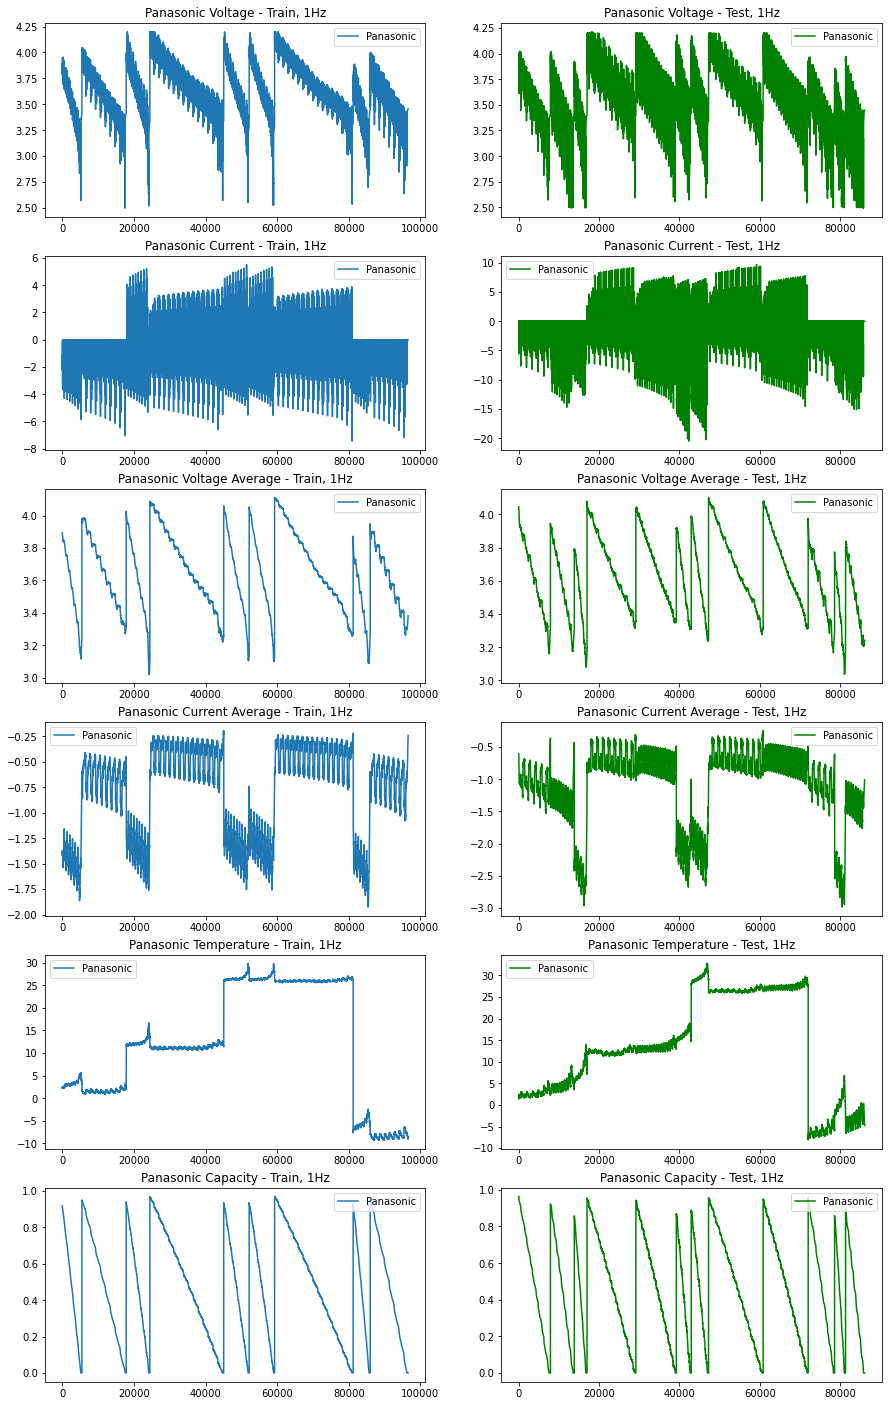

In [6]:
plot_cols = ['Voltage', 'Current', 'Voltage Average', 'Current Average', 'Temperature', 'Capacity']

fig, axs = plt.subplots(nrows=len(plot_cols), ncols=2, figsize=(15, 25))

for i, col in enumerate(plot_cols):
    axs[i, 0].plot(panasonic_train[col], label='Panasonic')
    axs[i, 0].set_title(f'Panasonic {col} - Train, 1Hz')
    axs[i, 0].legend()
    
    axs[i, 1].plot(panasonic_test[col], label='Panasonic', color="green")
    axs[i, 1].set_title(f'Panasonic {col} - Test, 1Hz')
    axs[i, 1].legend()

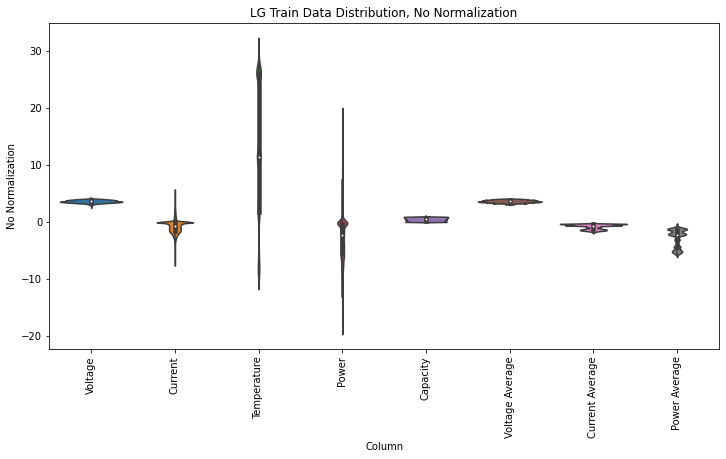

In [7]:
df_std = panasonic_train.melt(var_name='Column', value_name='No Normalization')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='No Normalization', data=df_std)
_ = ax.set_xticklabels(panasonic_train.keys(), rotation=90)
_ = ax.set_title(label='LG Train Data Distribution, No Normalization')

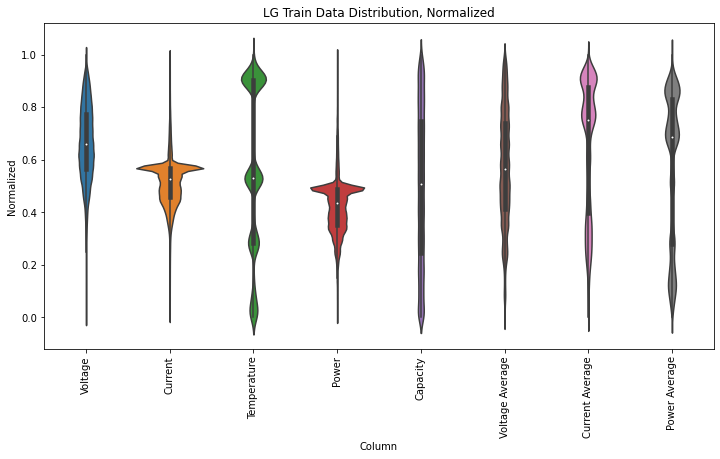

In [8]:
df_std = panasonic_train_norm.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(panasonic_train_norm.keys(), rotation=90)
_ = ax.set_title(label='LG Train Data Distribution, Normalized')

Text(0.5, 1.01, 'Pair Plot, LG Training Dataset')

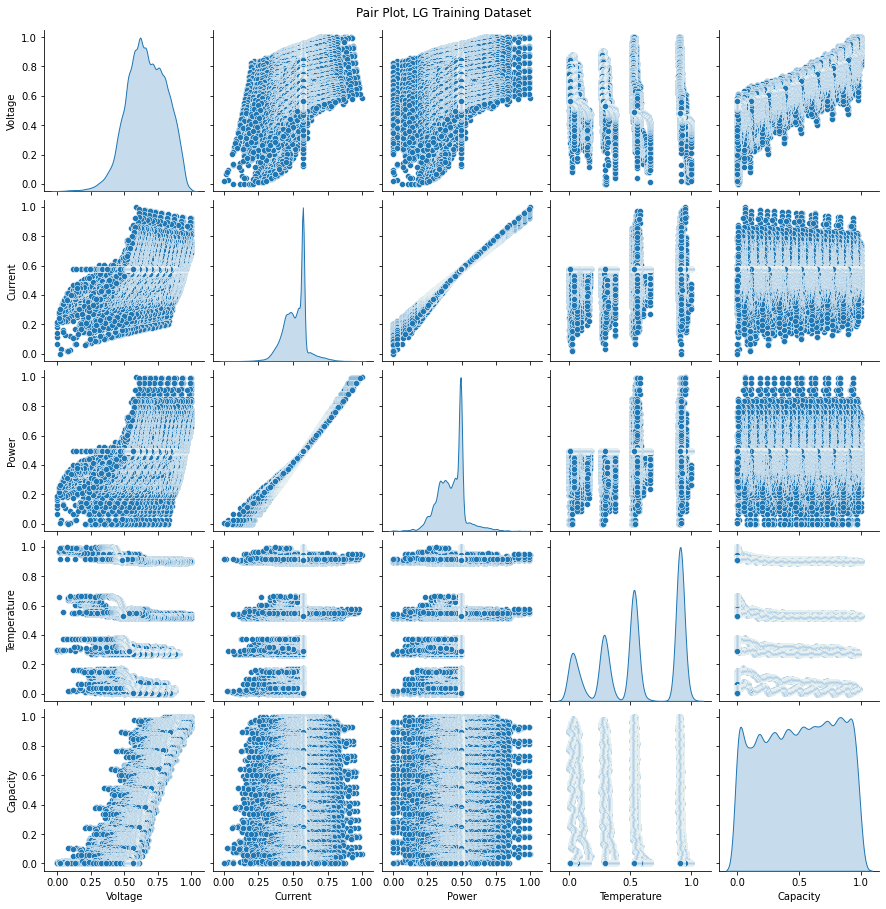

In [9]:
ax = sns.pairplot(panasonic_train_norm[['Voltage', 'Current', 'Power', 'Temperature', 'Capacity']], diag_kind='kde')
ax.fig.suptitle("Pair Plot, LG Training Dataset", y = 1.01) 

## LSTM MODEL TRAINING

In [5]:
# LSTM model architecture - https://github.com/KeiLongW/battery-state-estimation
opt = tf.keras.optimizers.Adam(lr=0.00001)

lstm_model = Sequential()
lstm_model.add(LSTM(256, activation='selu',
                    return_sequences=True,
                    input_shape=(train_x.shape[1], train_x.shape[2])))
lstm_model.add(LSTM(256, activation='selu', return_sequences=False))
lstm_model.add(Dense(256, activation='selu'))
lstm_model.add(Dense(128, activation='selu'))
lstm_model.add(Dense(1, activation='linear'))
lstm_model.summary()

lstm_model.compile(optimizer=opt, loss='huber', metrics=['mse', 'mae', 'mape', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

es = EarlyStopping(monitor='val_loss', patience=50)

/home/ap_surface/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-03-22 17:38:08.892394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 17:38:08.892536: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 17:38:08.892603: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (AP-Surface): /proc/driver/nvidia/version does not exist
2023-03-22 17:38:08.893101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300, 256)          268288    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 892,417
Trainable params: 892,417
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = lstm_model.fit(
    train_x, 
    train_y, 
    epochs=75, batch_size=32, 
    verbose=1, validation_split=0.2,
    callbacks = [es])

Epoch 1/75
81/81 [==============================] - 155s 2s/step - loss: 0.1251 - mse: 0.2974 - mae: 0.3034 - mape: 6838356.0000 - rmse: 0.5453 - val_loss: 0.0155 - val_mse: 0.0311 - val_mae: 0.1525 - val_mape: 9175940.0000 - val_rmse: 0.1763
Epoch 2/75
81/81 [==============================] - 128s 2s/step - loss: 0.0026 - mse: 0.0052 - mae: 0.0461 - mape: 4068653.7500 - rmse: 0.0720 - val_loss: 0.0172 - val_mse: 0.0343 - val_mae: 0.1604 - val_mape: 8160144.0000 - val_rmse: 0.1853
Epoch 3/75
81/81 [==============================] - 141s 2s/step - loss: 0.0019 - mse: 0.0037 - mae: 0.0344 - mape: 3250835.0000 - rmse: 0.0610 - val_loss: 0.0169 - val_mse: 0.0337 - val_mae: 0.1582 - val_mape: 7867143.5000 - val_rmse: 0.1836
Epoch 4/75
81/81 [==============================] - 141s 2s/step - loss: 0.0016 - mse: 0.0032 - mae: 0.0283 - mape: 3022860.7500 - rmse: 0.0565 - val_loss: 0.0104 - val_mse: 0.0207 - val_mae: 0.1185 - val_mape: 6137908.0000 - val_rmse: 0.1440
Epoch 5/75
81/81 [==========

## SAVE MODEL, EVALUATE

In [7]:
lstm_model.save(pre_trained_path)

# load pre-trained model
# model = tf.keras.models.load_model(pre_trained_path)

INFO:tensorflow:Assets written to: ../../pre-trained/panasonic_lstm_model/assets


In [8]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss       mse       mae        mape      rmse  val_loss   val_mse  \
70  0.001080  0.002160  0.018485  2281461.00  0.046477  0.005898  0.011796   
71  0.001162  0.002324  0.021116  2266860.00  0.048208  0.005462  0.010924   
72  0.001048  0.002097  0.017224  2200123.25  0.045788  0.005746  0.011492   
73  0.001176  0.002352  0.021021  2218071.25  0.048501  0.005662  0.011323   
74  0.001016  0.002032  0.015885  2241051.75  0.045082  0.008510  0.017021   

     val_mae   val_mape  val_rmse  epoch  
70  0.078301  6449054.5  0.108611     70  
71  0.068085  7116816.0  0.104520     71  
72  0.070407  6863907.0  0.107200     72  
73  0.074099  6770034.0  0.106411     73  
74  0.096657  7591175.0  0.130463     74

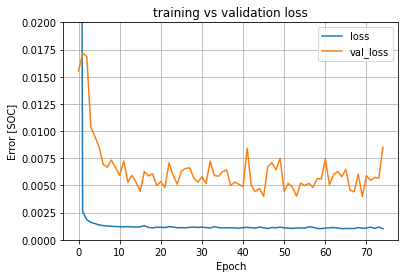

In [9]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.02])
    plt.xlabel('Epoch') 
    plt.ylabel('Error [SOC]')
    plt.title('training vs validation loss')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

90/90 - 53s - loss: 0.0065 - mse: 0.0131 - mae: 0.0774 - mape: 5580294.0000 - rmse: 0.1144 - 53s/epoch - 589ms/step
90/90 [==============================] - 53s 591ms/step


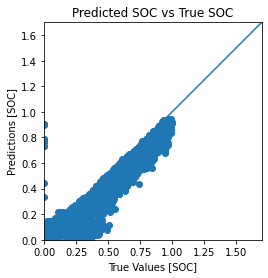

In [10]:
test_results = lstm_model.evaluate(test_x, test_y, verbose=2)
test_predictions = lstm_model.predict(test_x).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_y, test_predictions)
plt.xlabel('True Values [SOC]')
plt.ylabel('Predictions [SOC]')
lims = [0, 1.7]
plt.xlim(lims)
plt.ylim(lims)
plt.title('Predicted SOC vs True SOC')
_ = plt.plot(lims, lims)

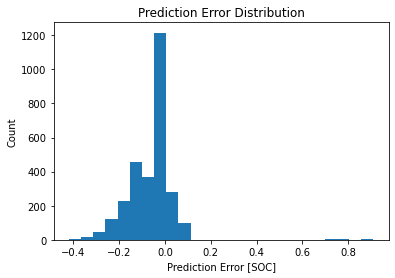

In [11]:
error = test_predictions - test_y.flatten()
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [SOC]')
plt.title('Prediction Error Distribution')
_ = plt.ylabel('Count')

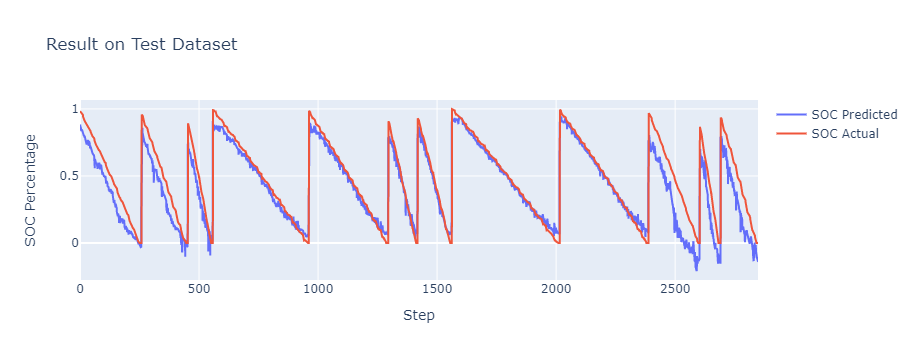

In [12]:
import plotly.graph_objects as go

cycle_num = 0
steps_num = 100000
step_index = np.arange(cycle_num*steps_num, (cycle_num+1)*steps_num)

fig = go.Figure()
fig.add_trace(go.Scatter(x=step_index, y=test_predictions.flatten()[cycle_num*steps_num:(cycle_num+1)*steps_num],
                    mode='lines', name='SOC Predicted'))
fig.add_trace(go.Scatter(x=step_index, y=test_y.flatten()[cycle_num*steps_num:(cycle_num+1)*steps_num],
                    mode='lines', name='SOC Actual'))
fig.update_layout(title='Result on Test Dataset',
                  xaxis_title='Step',
                  yaxis_title='SOC Percentage')
fig.show()